In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch

from torch import nn

In [3]:
import math
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(111)

# Prepare training data

In [5]:
train_data_length=1024

In [7]:
train_data=torch.zeros((train_data_length,2))

In [8]:
train_data[:,0]=2*math.pi*torch.rand(train_data_length)

In [9]:
#Takes the sin value of the first column

train_data[:,1]=torch.sin(train_data[:,0])

In [10]:
train_labels=torch.zeros(train_data_length)

In [11]:
train_set=[(train_data[i],train_labels[i]) for i in range(train_data_length)]

In [13]:
train_set

[(tensor([ 4.4960, -0.9767]), tensor(0.)),
 (tensor([ 5.7428, -0.5145]), tensor(0.)),
 (tensor([1.7710, 0.9800]), tensor(0.)),
 (tensor([1.6217, 0.9987]), tensor(0.)),
 (tensor([ 3.9654, -0.7337]), tensor(0.)),
 (tensor([ 3.7702, -0.5881]), tensor(0.)),
 (tensor([ 5.8509, -0.4190]), tensor(0.)),
 (tensor([1.3527, 0.9763]), tensor(0.)),
 (tensor([ 3.7905, -0.6043]), tensor(0.)),
 (tensor([ 4.6042, -0.9942]), tensor(0.)),
 (tensor([1.1669, 0.9195]), tensor(0.)),
 (tensor([ 3.2048, -0.0632]), tensor(0.)),
 (tensor([ 4.7404, -0.9996]), tensor(0.)),
 (tensor([1.8120, 0.9710]), tensor(0.)),
 (tensor([ 3.6283, -0.4678]), tensor(0.)),
 (tensor([0.2252, 0.2233]), tensor(0.)),
 (tensor([0.6448, 0.6011]), tensor(0.)),
 (tensor([2.1483, 0.8378]), tensor(0.)),
 (tensor([2.7645, 0.3682]), tensor(0.)),
 (tensor([ 3.9842, -0.7464]), tensor(0.)),
 (tensor([ 3.9106, -0.6954]), tensor(0.)),
 (tensor([ 3.9801, -0.7436]), tensor(0.)),
 (tensor([ 5.3908, -0.7786]), tensor(0.)),
 (tensor([0.9877, 0.8348]), t

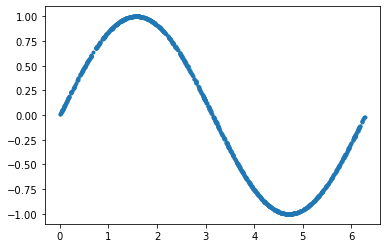

In [16]:
plt.plot(train_data[:,0],train_data[:,1],'.')

**Data loader**

In [17]:
batch_size=32

train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

# Creating discriminator

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

**The discriminator takes two data points and tells whether the data is real or fake,so it outputs one data that returns from the sigmoid**

In [19]:
discriminator = Discriminator()

# Creating generator

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [21]:
generator=Generator()

**In this case, it’s a model with a two-dimensional input, which will receive random points (z₁, z₂), and a two-dimensional output that must provide (x̃₁, x̃₂) points resembling those from the training data.**

# Train the models

In [22]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [23]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [24]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.156594917178154
Epoch: 0 Loss G.: 2.125444173812866
Epoch: 10 Loss D.: 0.7301511168479919
Epoch: 10 Loss G.: 0.8579633235931396
Epoch: 20 Loss D.: 0.5808133482933044
Epoch: 20 Loss G.: 1.126643419265747
Epoch: 30 Loss D.: 0.544232964515686
Epoch: 30 Loss G.: 0.9332916140556335
Epoch: 40 Loss D.: 0.6069112420082092
Epoch: 40 Loss G.: 0.9143486618995667
Epoch: 50 Loss D.: 0.5861774682998657
Epoch: 50 Loss G.: 0.843334436416626
Epoch: 60 Loss D.: 0.6483707427978516
Epoch: 60 Loss G.: 0.8372251391410828
Epoch: 70 Loss D.: 0.6814555525779724
Epoch: 70 Loss G.: 0.6812490820884705
Epoch: 80 Loss D.: 0.6955455541610718
Epoch: 80 Loss G.: 0.7143145203590393
Epoch: 90 Loss D.: 0.6394870281219482
Epoch: 90 Loss G.: 0.8582572937011719
Epoch: 100 Loss D.: 0.6732719540596008
Epoch: 100 Loss G.: 0.7465885281562805
Epoch: 110 Loss D.: 0.7188917398452759
Epoch: 110 Loss G.: 0.7073776125907898
Epoch: 120 Loss D.: 0.6644884943962097
Epoch: 120 Loss G.: 0.6788890361785889
Epoch: 130 Lo

In [25]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

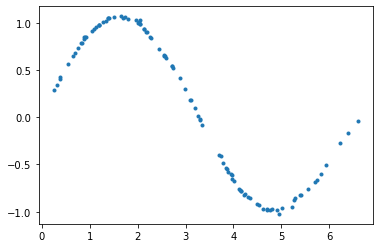

In [26]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

**We can see that the generated samples from the generator resembles the real sample of the sin wave**